### LIMPIEZA DE MIS DATOS

In [132]:
import pandas as pd
import numpy as np
import re
#------------------------------------------------Librerias para deteccion de idiomas
from langdetect import detect_langs
#------------------------------------------------Librerias para Data Scraping
from bs4 import BeautifulSoup
import requests


In [183]:
df_coursera_courses=pd.read_csv(r"Datasets/Coursera_courses.csv")
df_coursera_reviews=pd.read_csv(r"Datasets/Coursera_reviews.csv")
df_coursera_ad=pd.read_csv(r"Datasets/Coursera_data.csv")
df_edx_courses=pd.read_csv(r"Datasets/edx_courses.csv")
df_udemy_courses=pd.read_csv(r"Datasets/udemy_courses.csv")

In [5]:

#Agrego la columna "plataforms" para indicar a que plataforma corresponden los cursos
df_coursera_courses["platform"]="coursera"
df_coursera_ad["platform"]="coursera"
df_edx_courses["platform"]="edx"
df_udacity["platform"]="udacity"
df_udemy_courses["platform"]="udemy"

#### ANALIZO MIS DATASETS

##### PLATAFORMA `Coursera`

In [6]:
df_coursera_courses.head(2)

,name,institution,course_url,course_id,platform
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,coursera
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada,coursera


In [7]:
df_coursera_reviews.head(2)

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training


In [8]:
df_coursera_ad.head(2)

,Unnamed: 0,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,platform
0,134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k,coursera
1,743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k,coursera


`ID`: Quiero verificar si mis columnas course_id de mi df_coursera_courses, es correspondiente con df_coursera_reviews

In [9]:
#Analizo mis datos unicos en mi df_coursera_courses.course_id
np.sort(df_coursera_courses.course_id.unique())

array(['aboriginal-education', 'access-control-sscp',
       'accounting-analytics', 'accounting-data-analytics-python',
       'actualizacion-manejo-diabetes-tipo-2', 'addiction-and-the-brain',
       'addiction-treatment', 'advanced-valuation-and-strategy',
       'agile-atlassian-jira', 'ai-for-everyone',
       'ai-for-medical-diagnosis', 'ai-for-medical-prognosis',
       'algorithmic-toolbox', 'algorithms-divide-conquer', 'american-law',
       'analytics-business-metrics', 'analytics-excel',
       'analytics-tableau', 'anatomy403-1x', 'animal-welfare',
       'antibiotic-stewardship', 'anticorrupcion-introduccion',
       'applied-data-science-capstone', 'aprendiendo-a-aprender',
       'aprendiendo-programar-python',
       'arbitration-international-disputes', 'arts-heritage', 'astro',
       'attention-models-in-nlp', 'aulaconstructivista',
       'autism-spectrum-disorder', 'autodesk-autocad-design-drafting',
       'autodesk-revit-architectural-design',
       'aws-fundame

In [10]:
df_coursera_reviews.head(2)

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training


In [11]:
#Analizo mis datos unicos de course_id en mi df_coursera_reviews
np.sort(df_coursera_reviews.course_id.unique())

array(['aboriginal-education', 'access-control-sscp',
       'accounting-analytics', 'accounting-data-analytics-python',
       'actualizacion-manejo-diabetes-tipo-2', 'addiction-and-the-brain',
       'addiction-treatment', 'advanced-valuation-and-strategy',
       'agile-atlassian-jira', 'ai-for-everyone',
       'ai-for-medical-diagnosis', 'ai-for-medical-prognosis',
       'algorithmic-toolbox', 'american-law',
       'analytics-business-metrics', 'analytics-excel', 'anatomy403-1x',
       'animal-welfare', 'antibiotic-stewardship',
       'anticorrupcion-introduccion', 'applied-data-science-capstone',
       'aprendiendo-a-aprender', 'aprendiendo-programar-python',
       'arbitration-international-disputes', 'arts-heritage', 'astro',
       'attention-models-in-nlp', 'aulaconstructivista',
       'autism-spectrum-disorder', 'autodesk-autocad-design-drafting',
       'autodesk-revit-architectural-design',
       'aws-fundamentals-addressing-security-risk',
       'aws-fundamentals

`MERGE`: Como se verifica que ambas columnas son identicas, voy a proceder a hacer un merge de estos datasets.

In [12]:
df_coursera_beta= df_coursera_courses.merge(df_coursera_reviews, on='course_id')

`ENROLLED`: Ahora procedo a organizar la informacion de la cantidad de inscriptos por el nombre de cada curso. Adicionalmente a esto, voy a dejar un unico registro de los cursos y crear la columna "enrolled" para denotar esta cantidad.

In [13]:
#Reviso la cantidad de cursos diferentes
np.sort(df_coursera_beta.name.unique()).shape

(603,)

In [14]:
#Creo la columna "enrolled" con la cantidad de inscriptos a un mismo curso. Elimino duplicados de mi campo name. Reseteo el indice.
df_coursera_beta['enrolled'] = df_coursera_beta.groupby('name')['name'].transform('size')
df_coursera_beta = df_coursera_beta.drop_duplicates(subset='name')
df_coursera_beta = df_coursera_beta.sort_values('name').reset_index(drop=True)

Hasta aca tenemos en mis datasets principales el campo enrolled y course_students_enrolled. Procedo a conservar el nombre enrolled y corrijo el nombre en df_coursera_ad.

In [15]:
df_coursera_ad = df_coursera_ad.rename(columns={'course_students_enrolled': 'enrolled'})

Procedemos a la normalizacion de la informacion. En los campos tenemos el numero de inscriptos representados de dos maneras, como enteros y como notacion de unidades. Llevo a ambos como enteros.

In [16]:
df_coursera_beta["enrolled"][0:1]

0    270
Name: enrolled, dtype: int64

In [17]:
df_coursera_ad["enrolled"][0:1]

0    5.3k
Name: enrolled, dtype: object

In [18]:
def convert_number(number):
    if '.' in number and 'k' in number:
        number = number.replace('.', '').replace('k', '')
        number = int(number) * 100
    elif 'k' in number:
        number = number.replace('k', '')
        number = int(number) * 1000
    elif '.' in number and 'm' in number:
        number = number.replace('.', '').replace('m', '')
        number = int(number) * 100000
    elif 'm' in number:
        number = number.replace('m', '')
        number = int(number) * 1000000
    return number


In [19]:
# Aplicar la función a la columna 'enrolled'
df_coursera_ad['enrolled'] = df_coursera_ad['enrolled'].apply(convert_number)

In [20]:
df_coursera_ad["enrolled"][0:1]

0    5300
Name: enrolled, dtype: int64

`IDIOMA`: Como requisito para este proyecto, se nos pide saber el idioma de nuestros cursos. Procedo a crear los registros del campo "language", mediante la identificacion del idioma del nombre del curso.

In [21]:
# Diccionario de mapeo de idiomas y abreviaturas correspondientes
language_mapping = {
    'en': 'en',
    'es': 'es',
    'fr': 'fr',
    'de': 'de',
    'zh': 'zh',
    'ja': 'ja',
    'ko': 'ko',
    'ru': 'ru',
    'pt': 'pt',
    'it': 'it',
    'nl': 'nl',
    'tr': 'tr',
    'ar': 'ar',
    'sv': 'sv',
    'pl': 'pl',
    'da': 'da',
    'no': 'no',
    'fi': 'fi',
    'el': 'el',
    'cs': 'cs',
    'hu': 'hu',
    'he': 'he',
    'id': 'id',
    'th': 'th',
    'hi': 'hi',
    'vi': 'vi',
    'ms': 'ms',
    'uk': 'uk',
    'bg': 'bg',
    'ro': 'ro',
    'sk': 'sk',
    'sl': 'sl',
    'hr': 'hr',
    'sr': 'sr',
    'et': 'et',
    'lv': 'lv',
    'lt': 'lt'
}

# Función para obtener la abreviatura del idioma
def get_language(text):
    try:
        lang_probs = detect_langs(text)
        lang = lang_probs[0].lang if lang_probs else 'Unknown'
        return language_mapping.get(lang.lower(), 'Other')
    except:
        return 'Unknown'

# Crear el campo "language" utilizando la función get_language
df_coursera_beta['language'] = df_coursera_beta['name'].apply(get_language)

# Verificar los resultados
print(df_coursera_beta.head())


                                                name  \
0  A Crash Course in Causality:  Inferring Causal...   
1                            A Law Student's Toolkit   
2                                    AI For Everyone   
3                           AI for Medical Diagnosis   
4                           AI for Medical Prognosis   

                  institution  \
0  University of Pennsylvania   
1             Yale University   
2             DeepLearning.AI   
3             DeepLearning.AI   
4             DeepLearning.AI   

                                          course_url  \
0  https://www.coursera.org/learn/crash-course-in...   
1         https://www.coursera.org/learn/law-student   
2     https://www.coursera.org/learn/ai-for-everyone   
3  https://www.coursera.org/learn/ai-for-medical-...   
4  https://www.coursera.org/learn/ai-for-medical-...   

                   course_id  platform  \
0  crash-course-in-causality  coursera   
1                law-student  coursera   
2

In [22]:
df_coursera_beta.describe(include=['object']).T

,count,unique,top,freq
name,603,603,A Crash Course in Causality: Inferring Causal...,1
institution,603,132,University of Pennsylvania,43
course_url,603,603,https://www.coursera.org/learn/crash-course-in...,1
course_id,603,603,crash-course-in-causality,1
platform,603,1,coursera,603
reviews,603,602,I did all four courses - the whole specializat...,2
reviewers,603,584,By Deleted A,8
date_reviews,603,458,"Jul 17, 2020",6
language,603,15,en,502


Ahora aplico esta funcion a df_coursera_ad

In [23]:
#Redefino el nombre course_title por name
df_coursera_ad = df_coursera_ad.rename(columns={'course_title': 'name'})

In [24]:
#aplico la funcion language
df_coursera_ad['language'] = df_coursera_ad['name'].apply(get_language)
df_coursera_ad.head()

,Unnamed: 0,name,course_organization,course_Certificate_type,course_rating,course_difficulty,enrolled,platform,language
0,134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5300,coursera,en
1,743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17000,coursera,en
2,874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130000,coursera,en
3,413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91000,coursera,en
4,635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320000,coursera,en


`DUPLICADOS`: Reviso mi df_coursera_courses para saber si tengo coincidencias con mis cursos de data_coursera_beta

In [25]:
df_coursera_ad.describe(include=['object']).T

,count,unique,top,freq
name,891,888,Developing Your Musicianship,2
course_organization,891,154,University of Pennsylvania,59
course_Certificate_type,891,3,COURSE,582
course_difficulty,891,4,Beginner,487
platform,891,1,coursera,891
language,891,17,en,716


In [26]:
df_coursera_ad = df_coursera_ad.drop_duplicates(subset='name')
df_coursera_ad = df_coursera_ad.sort_values('name').reset_index(drop=True)

`TIPOS`: Quiero analizar los tipos de cursos de mis datasets.

In [27]:
#Analizo mis datos unicos en mi df_coursera_reviews.course_id
np.sort(df_coursera_ad.course_Certificate_type.unique())

array(['COURSE', 'PROFESSIONAL CERTIFICATE', 'SPECIALIZATION'],
      dtype=object)

Ahora por lo que vemos, tenemos 3 tipos para este campo en mi df_coursera_ad. Como mi proyecto solo se trata unicamente de cursos, podemos inferir que mi merge df_coursera_beta solo contiene el tipo "COURSE". Para darnos cuenta de esto tenemos que ver que en la URL de los cursos aportados, deben de aparecer las palabras clave ../learn/.. para "COURSE", ..//.. para "PROFESIONAL CERTIFICATE" y ..//.. para "SPECIALIZATION". Procedo a armar un identificador y crear la columna "course_type".

In [28]:
# Definir las condiciones y los valores correspondientes
conditions = [
    df_coursera_beta['course_url'].str.contains('/learn/'),
    df_coursera_beta['course_url'].str.contains('/professional-certificates/'),
    df_coursera_beta['course_url'].str.contains('/specializations/')
]

values = ['COURSE', 'PROFESSIONAL CERTIFICATE', 'SPECIALIZATION']

In [29]:
# Asignar los valores basados en las condiciones
df_coursera_beta['course_type'] = np.select(conditions, values, default='Other')

In [30]:
#Analizo mis datos unicos de course_type en mi df_coursera_courses
np.sort(df_coursera_beta.course_type.unique())

array(['COURSE'], dtype=object)

Finalmente podemos verificar que efectivamente todos los tipos de nuestro df_coursera_beta son del tipo "COURSE".

Cambio el nombre course_Certificate_type de mi campo df_coursera_ad, a curse_type.

In [31]:
#Redefino el nombre course_title por name
df_coursera_ad = df_coursera_ad.rename(columns={'course_Certificate_type': 'course_type'})

`RATING`: Quiero introducir mi campo rating en mi df_coursera_beta. Para esto realizo algo de scraping mediante las URLs proporcionadas.

Primero voy a almacenar mi texto de mi URL en una variable

In [32]:
df_coursera_beta["course_url"][0]

'https://www.coursera.org/learn/crash-course-in-causality'

In [33]:
website=df_coursera_beta["course_url"][0] #creo una variable website y agrego mi url
result = requests.get(website) #Creo una variable result donde voy a "guardar" mi pagia web
content = result.text #Creo la variable content donde voy a almacenar el texto de mi pagina

Al contenido de mi variable content lo trabajamos con soup.prettify()

<!DOCTYPE html>
<html dir="ltr" itemtype="http://schema.org" lang="en" xmlns:fb="http://ogp.me/ns/fb#">
 <head>
  <link crossorigin="" href="https://d3njjcbhbojbot.cloudfront.net" rel="preconnect"/>
  <meta content="IE=Edge,chrome=IE7" http-equiv="X-UA-Compatible"/>
  <meta charset="utf-8"/>
  <meta content="Coursera" property="og:site_name"/>
  <meta content="727836538,4807654" property="fb:admins"/>
  <meta content="823425307723964" property="fb:app_id"/>
  <meta content="Coursera" name="twitter:site"/>
  <meta content="Coursera" name="twitter:app:name:iphone"/>
  <meta content="Coursera" name="twitter:app:name:ipad"/>
  <meta content="Coursera" name="twitter:app:name:googleplay"/>
  <meta content="id736535961" name="twitter:app:id:iphone"/>
  <meta content="id736535961" name="twitter:app:id:ipad"/>
  <meta content="org.coursera.android" name="twitter:app:id:googleplay"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <link href="https://d3njjcbhbojbot.clou
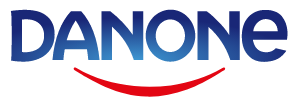

In [34]:
soup=BeautifulSoup(content, "lxml") #creo la variable soup, que es muy importante por que nos permite localizar elementos en una pagina web.
                                    #Adicionalmente en el argumento de beautifulsoup colocamos(content, "html.parser" ) que en este caso mi parser es "lxml".
                                    #content si bien tiene almacenado mi texto de mi pagina, lo tenemos disponible como un string larguisimo.
print(soup.prettify())              #para poder ver bien el contenido de content, debemos utilizarlo atravez de nuestra variable soup.prettify()


Ahora para buscar un elemento en mi texto html, debo de serguir una serie de pasos en orden:  
1-id  
2-Class name  
3-Tag name, css selector  
4-Xpath

Buscamos la informacion dentro de nuestra clase y tag

In [35]:
rating=soup.find("span", class_="_16ni8zai m-b-0 rating-text number-rating m-l-1s m-r-1").get_text() #find para buscar solo un elemento y find_all para varios. 
                                                                                                     #find("tag name", class_="Class name")
# titulo=box.find("h1").get_text() #creo la variable rating donde se va a almacenar mi informacion extraida. Esto me sirve para localizar info dentro de elementos.
print(rating)                                                                                       

4.7stars


Finalmente la transformamos para que solo nos quede el numero como variable flotante.

In [36]:
pattern = r"\d+(\.\d+)?"
match = re.search(pattern, rating)
if match:
    numeric_part = match.group()
    numeric_value = float(numeric_part)
    print(numeric_value)
else:
    print(None)

4.7


Como podemos ver conseguimos de manera eficas la informacion rating con nuestra URL. Ahora procedemos a crear una funcion que nos cree el campo "ratings".

In [37]:
def rating_scraping(url):
    website = url
    result = requests.get(website)
    content = result.text
    soup = BeautifulSoup(content, "lxml")
    rating_element = soup.find("span", class_="_16ni8zai m-b-0 rating-text number-rating m-l-1s m-r-1")
    
    if rating_element:
        rating = rating_element.get_text()
        pattern = r"\d+(\.\d+)?"
        match = re.search(pattern, rating)
        
        if match:
            numeric_part = match.group()
            numeric_value = float(numeric_part)
            return numeric_value
    
    return None


In [39]:
#Aplico mi funcion rating_scraping
df_coursera_beta['rating'] = df_coursera_beta['course_url'].apply(rating_scraping)
df_coursera_beta.head()

,name,institution,course_url,course_id,platform,reviews,reviewers,date_reviews,rating,enrolled,language,course_type
0,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,https://www.coursera.org/learn/crash-course-in...,crash-course-in-causality,coursera,Can not download slides which make the source ...,By Eva Y G,"Sep 29, 2019",4.7,270,en,COURSE
1,A Law Student's Toolkit,Yale University,https://www.coursera.org/learn/law-student,law-student,coursera,"This course was required by my director, but i...",By Kathy M,"May 01, 2017",4.7,783,en,COURSE
2,AI For Everyone,DeepLearning.AI,https://www.coursera.org/learn/ai-for-everyone,ai-for-everyone,coursera,"Very general, as a large chunck of it could ap...",By Jean-Philippe B,"Aug 27, 2019",4.8,21630,en,COURSE
3,AI for Medical Diagnosis,DeepLearning.AI,https://www.coursera.org/learn/ai-for-medical-...,ai-for-medical-diagnosis,coursera,Too basic,By Jesús F B,"Apr 19, 2020",4.7,767,it,COURSE
4,AI for Medical Prognosis,DeepLearning.AI,https://www.coursera.org/learn/ai-for-medical-...,ai-for-medical-prognosis,coursera,The videos were too short and seem to be missi...,By Scott V,"Apr 29, 2020",4.7,219,it,COURSE


Corroboramos la informacion de mi campo "ratings"

In [40]:
np.sort(df_coursera_beta.rating.unique())

array([3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, nan])

Elimino valores nulos

In [41]:
df_coursera_beta.dropna(subset=['rating'], inplace=True)

In [42]:
np.sort(df_coursera_beta.rating.unique())

array([3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])

`DETALLES`: Termino mis datasets normalizando campos, eliminando columnas, etc.

In [63]:
df_coursera_beta.head(2)


,name,institution,platform,rating,enrolled,language,course_type
0,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,coursera,4.7,270,en,COURSE
1,A Law Student's Toolkit,Yale University,coursera,4.7,783,en,COURSE


Elimino las columnas "course_url", "course_id", "reviewes","reviewers", "date_reviews" y "reviewes". Mi ETL presento una serie de problemas y tuve que terminar eliminando practicamente mi df_coursera_reviews, pero lo voy a utilizar aparte.

In [49]:
df_coursera_beta.drop(["course_url", "course_id", "reviews", "reviewers", "date_reviews"], axis=1, inplace=True)


In [50]:
df_coursera_beta.head(2)

,name,institution,platform,rating,enrolled,language,course_type
0,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,coursera,4.7,270,en,COURSE
1,A Law Student's Toolkit,Yale University,coursera,4.7,783,en,COURSE


In [117]:
df_coursera_beta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               571 non-null    object 
 1   institution        571 non-null    object 
 2   platform           571 non-null    object 
 3   rating             571 non-null    float64
 4   enrolled           571 non-null    int64  
 5   language           571 non-null    object 
 6   course_type        571 non-null    object 
 7   course_difficulty  0 non-null      object 
dtypes: float64(1), int64(1), object(6)
memory usage: 35.8+ KB


In [118]:
df_coursera_ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               888 non-null    object 
 1   institution        888 non-null    object 
 2   course_type        888 non-null    object 
 3   rating             888 non-null    float64
 4   course_difficulty  888 non-null    object 
 5   enrolled           888 non-null    int64  
 6   platform           888 non-null    object 
 7   language           888 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 55.6+ KB


Elimino la columnas Unnamed: 0 de df_cousera_ad

In [51]:
df_coursera_ad.drop("Unnamed: 0", axis=1, inplace=True)

Redefino nombres de mis columnas

In [99]:
df_coursera_ad = df_coursera_ad.rename(columns={'course_organization': 'institution'})
df_coursera_ad = df_coursera_ad.rename(columns={'course_rating': 'rating'})

In [100]:
df_coursera_ad.columns

Index(['name', 'institution', 'course_type', 'rating', 'course_difficulty',
       'enrolled', 'platform', 'language'],
      dtype='object')

Veo si tengo registros repetidos en ambos df.

In [69]:
#Veo cuantos cursos se corresponden entre mis dos df.
num_registros_identicos = df_coursera_beta["name"].isin(df_coursera_ad["name"]).sum()
print("Número de registros idénticos:", num_registros_identicos)

Número de registros idénticos: 436


`MERGE2`: Ahora lo que voy a proceder a hacer es realizar un NUEVO merge entre mis dataframes.

In [123]:

# Realizar el merge de los DataFrames
merged_df = df_coursera_ad.merge(df_coursera_beta, on='name', how='left')

# Seleccionar solo las columnas deseadas de df_coursera_ad
df_coursera_ETL = merged_df[['name', 'institution_x', 'course_type_x', 'rating_x', 'course_difficulty_x',
                             'enrolled_x', 'platform_x', 'language_x']].copy()

# Renombrar columnas seleccionadas
df_coursera_ETL = df_coursera_ETL.rename(columns={'institution_x': 'institution', 'course_type_x': 'course_type',
                                                  'rating_x': 'rating', 'course_difficulty_x': 'course_difficulty',
                                                  'enrolled_x': 'enrolled', 'platform_x': 'platform',
                                                  'language_x': 'language'})




In [130]:
df_coursera_ETL.head()

,name,institution,course_type,rating,course_difficulty,enrolled,platform,language
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5300,coursera,en
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17000,coursera,en
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130000,coursera,en
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91000,coursera,en
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320000,coursera,en


`EXPORT`: Guardo mi ETL para EDA.

In [127]:
#Exporto mi csv
df_coursera_ETL.to_csv(r'Datasets/ParaEDA/coursera_ETL.csv',index=False)

##### PLATAFORMA `EDX`

In [75]:
df_edx_courses.describe(include=['object']).T

,count,unique,top,freq
title,975,972,Introduction to Probability,2
summary,922,887,This course is part of a MicroMasters® Program,15
n_enrolled,855,849,"97,291",2
course_type,975,2,Self-paced on your time,917
institution,975,111,Harvard University,104
instructors,972,775,Rafael Irizarry,9
Level,975,3,Introductory,621
subject,975,31,Computer Science,166
language,975,9,English,777
subtitles,972,33,English,713


In [166]:
df_edx_courses.head(10)

,name,enrolled,course_type,institution,course_difficulty,language,subtitles,effort(hs)_week,length_weeks,cost,course_description,platform
0,'Talk to me': Improving mental health and suic...,11481,Self-paced on your time,Curtin University,Introductory,English,English,2.5,6,139,"Poor mental health affects one in four people,...",edx
1,18th-Century Opera: Handel & Mozart,18331,Self-paced on your time,Harvard University,Introductory,English,English,3.5,5,99,"In this breathtaking course, you'll get to kno...",edx
2,"19th-Century Opera: Meyerbeer, Wagner, & Verdi",9340,Self-paced on your time,Harvard University,Introductory,English,English,4.0,6,99,Travel through central Europe in the 1800s to ...,edx
3,A Hands-on Introduction to Engineering Simulat...,187138,Self-paced on your time,Cornell University,Intermediate,English,English,5.0,6,199,"In this hands-on course, you'll learn how to p...",edx
4,A System View of Communications: From Signals ...,34261,Self-paced on your time,The Hong Kong University of Science and Techno...,Introductory,English,English,5.0,7,60,Have you ever wondered how information is tran...,edx
6,A-level Mathematics for Year 12 - Course 1: Al...,22366,Self-paced on your time,Imperial College London,Intermediate,English,English,3.0,7,49,NaN,edx
7,A-level Mathematics for Year 12 - Course 2: Ca...,6232,Self-paced on your time,Imperial College London,Intermediate,English,English,3.0,7,49,NaN,edx
8,A-level Mathematics for Year 13 - Course 1: Fu...,6594,Self-paced on your time,Imperial College London,Intermediate,English,English,3.0,7,49,NaN,edx
10,AI Applications with Watson,9173,Self-paced on your time,IBM,Intermediate,English,English,3.0,3,99,"By enrolling in this course, chances are you'v...",edx
11,AI Chatbots without Programming,35440,Self-paced on your time,IBM,Introductory,English,English,3.0,2,99,Special Offer : This course includes a great o...,edx


`NOMBRES`: Redefino los nombres de mis campos de mi dataframe.

In [131]:
df_edx_courses = df_edx_courses.rename(columns={'title': 'name'})
df_edx_courses = df_edx_courses.rename(columns={'n_enrolled': 'enrolled'})
df_edx_courses = df_edx_courses.rename(columns={'Level': 'course_difficulty'})
df_edx_courses = df_edx_courses.rename(columns={'price': 'cost'})


`DROP`:Elimino columnas innecesarias.

In [133]:
df_edx_courses.drop(["summary", "instructors", "subject", "course_syllabus", "course_url"], axis=1, inplace=True)

`DUPLICADOS`:Eliminos valores duplicados.

In [135]:
df_edx_courses = df_edx_courses.drop_duplicates(subset='name')
df_edx_courses = df_edx_courses.sort_values('name').reset_index(drop=True)

`NULL/ING`: Elimino valores nulos e infinitos.

In [148]:
# Eliminar valores nulos
df_edx_courses = df_edx_courses.dropna(subset=["enrolled"])

# Eliminar valores infinitos
df_edx_courses["enrolled"] = df_edx_courses["enrolled"].replace([np.inf, -np.inf], np.nan).dropna()

`TIPO`:Cambio el tipo de los campos.

In [149]:
df_edx_courses["enrolled"] = df_edx_courses["enrolled"].str.replace(',', '').astype(float)
df_edx_courses["enrolled"]=df_edx_courses["enrolled"].astype(int)

`COST`: Transformo mi informacion para dejar solo el valor.

In [153]:
# Función para extraer el número entero del campo "cost"
def extract_integer_cost(value):
    pattern = r"\$(\d+)"
    match = re.search(pattern, value)
    if match:
        return int(match.group(1))
    else:
        return None

In [154]:
df_edx_courses["cost"] = df_edx_courses["cost"].apply(extract_integer_cost)

`course_effort`: Como este campo me indica la cantidad horas por semana, solo voy a dejar el promedio del minimo y maximo de los intervalos dados.

In [157]:
# Función para extraer el número float promedio del campo "course_effort"
def extract_average_effort(value):
    pattern = r"(\d+(?:\.\d+)?)–(\d+(?:\.\d+)?)"
    match = re.search(pattern, value)
    if match:
        min_effort = float(match.group(1))
        max_effort = float(match.group(2))
        average_effort = (min_effort + max_effort) / 2
        return average_effort
    else:
        return None

In [158]:
df_edx_courses["course_effort"] = df_edx_courses["course_effort"].apply(extract_average_effort)

In [161]:
#Renombro
df_edx_courses = df_edx_courses.rename(columns={'course_effort': 'effort(hs)_week'})

`Course_length`:Solo quiero dejar el numero de semanas.

In [163]:
# Función para extraer el número entero del campo "course_length"
def extract_integer_length(value):
    pattern = r"(\d+)"
    match = re.search(pattern, value)
    if match:
        return int(match.group(1))
    else:
        return None

# Aplicar la función a la columna "course_length"
df_edx_courses["course_length"] = df_edx_courses["course_length"].apply(extract_integer_length)

In [165]:
#Renombro
df_edx_courses = df_edx_courses.rename(columns={'course_length': 'length_weeks'})

`EXPORT`: Guardo mi ETL para EDA.

In [206]:
df_edx_courses.to_csv(r'Datasets/ParaEDA/edx_ETL.csv',index=False)

##### PLATAFORMA `Udemy`

In [76]:
df_udemy_courses.describe(include=['object']).T

,count,unique,top,freq
course_title,3678,3663,Acoustic Blues Guitar Lessons,3
url,3678,3672,https://www.udemy.com/cfa-level-2-quantitative...,2
level,3678,4,All Levels,1929
published_timestamp,3678,3672,2017-07-02T14:29:35Z,2
subject,3678,4,Web Development,1200
platform,3678,1,udemy,3678


In [205]:
df_udemy_courses.head()

,name,cost,enrolled,course_difficulty,duration_wk,date,subject,platform
0,#1 Piano Hand Coordination: Play 10th Ballad i...,35,3137,All Levels,1.5,2014-09-18,Musical Instruments,udemy
1,#10 Hand Coordination - Transfer Chord Ballad ...,75,1593,Intermediate Level,1.0,2017-04-12,Musical Instruments,udemy
2,#12 Hand Coordination: Let your Hands dance wi...,75,482,Intermediate Level,1.5,2017-04-26,Musical Instruments,udemy
3,#4 Piano Hand Coordination: Fun Piano Runs in ...,75,850,Intermediate Level,1.0,2017-02-21,Musical Instruments,udemy
4,#5 Piano Hand Coordination: Piano Runs in 2 ...,75,940,Intermediate Level,0.6,2017-02-21,Musical Instruments,udemy


`NOMBRES`: Redefino los nombres de mis campos de mi dataframe.

In [202]:
df_udemy_courses = df_udemy_courses.rename(columns={'course_title': 'name'})
df_udemy_courses = df_udemy_courses.rename(columns={'price': 'cost'})
df_udemy_courses = df_udemy_courses.rename(columns={'num_subscribers': 'enrolled'})
df_udemy_courses = df_udemy_courses.rename(columns={'level': 'course_difficulty'})
df_udemy_courses = df_udemy_courses.rename(columns={'content_duration': 'duration_wk'})
df_udemy_courses = df_udemy_courses.rename(columns={'published_timestamp': 'date'})

`DROP`:Elimino columnas innecesarias.

In [173]:
df_udemy_courses.drop(["course_id", "url", "is_paid", "num_reviews", "num_lectures"], axis=1, inplace=True)

`DUPLICADOS`:Eliminos valores duplicados.

In [175]:
df_udemy_courses = df_udemy_courses.drop_duplicates(subset='name')
df_udemy_courses = df_udemy_courses.sort_values('name').reset_index(drop=True)

`NULL/ING`: Elimino valores nulos e infinitos.

In [187]:
# Eliminar valores nulos
df_udemy_courses = df_udemy_courses.dropna(subset=["cost"])
df_udemy_courses = df_udemy_courses.dropna(subset=["enrolled"])
df_udemy_courses = df_udemy_courses.dropna(subset=["duration_hs"])

# Eliminar valores infinitos
df_udemy_courses["cost"] = df_udemy_courses["cost"].replace([np.inf, -np.inf], np.nan).dropna()
df_udemy_courses["enrolled"] = df_udemy_courses["enrolled"].replace([np.inf, -np.inf], np.nan).dropna()
df_udemy_courses["duration_hs"] = df_udemy_courses["duration_hs"].replace([np.inf, -np.inf], np.nan).dropna()

`TIPO`:Cambio el tipo de los campos.

In [198]:
# Convertir el campo "date" a tipo datetime con formato específico
df_udemy_courses["date"] = pd.to_datetime(df_udemy_courses["date"], format="%Y-%m-%d",errors='coerce')
# Formatear la fecha como AAAA-mm-dd
df_udemy_courses["date"] = df_udemy_courses["date"].dt.strftime("%Y-%m-%d")


`duration_wk`: Redondeo a un decimal este campo.

In [204]:
# Redondear el campo "duration_wk" a un solo dígito decimal
df_udemy_courses["duration_wk"] = df_udemy_courses["duration_wk"].round(1)

`EXPORT`: Guardo mi ETL para EDA.

In [207]:
df_udemy_courses.to_csv(r'Datasets/ParaEDA/udemy_ETL.csv',index=False)